# Classification 101 - Step By Step Predicting Survival on Titanic | Kaggle

Maryam Ashoori 

_Requirements: Scikit-learn 0.20_
![](https://i.imgur.com/QoK4WwK.png)

In this notebook, we review and compare the performance of following classifiers on Titanic data.

- Logistic Classifier
- Stochastic Gradient Descent (SGD) Classifier
- Support Vector Machine (SVM)
- Bagging Classifier
- Extra Trees Classifier
- Random Forest Classifier
- k-Nearest Neighbors
- AdaBoost Classifier
- GradientBoosting Classifier
- Voting Classifier

# Step 1: Setup and importing data
## a. Preparing the environment
First thing first, let's import all the libraries, packages, and modules that we need for running these models.
I like to organize and list all dependancies at the top of the code. This will allow us to review in one glance what's happening in the code.

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()

# Feature Engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# Classification Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter Tuning
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Performance Measures
from sklearn.metrics import accuracy_score

# Global Variables
rnd_state = 42
skfold = StratifiedKFold(n_splits=5)

# Step 1: Importing data

In [119]:
train_data = pd.read_csv("../datasets/kaggle/titanic/train.csv")
test_data = pd.read_csv("../datasets/kaggle/titanic/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The test data does not contain survival labels: your goal is to train the best model you can using the training data, then make your predictions on the test data and upload them to Kaggle to see your final score. This code gives you slightly more than 80% accuracy.

# Step 2: Creating a Validation Set 

We use the validation set to test out the performance of the training models. The simplest way to create a validation set is to use train_test_split function and specify the percentage of data that you would want to allocate for validation. This will splits the training data into two sets of training and validation. For example, the code below creates a validation set with 20% of the data.

train_set, validation_set, survival_labels, validation_labels = train_test_split(train_data, train_data["Survived"], test_size=0.20, random_state=42)

Now that you know the simple way, let's apply a more sophisticated split that tries to preserve the distribution of the features we care more about. This is particularly helpful in situation where an expert tells you a feature is more important than others, or you run a set of feature importance analysis and realize one or two categories are more important than the others. Dont worry about the feature importance for now. we will revisit in step 4. Based on my analysis, Fare and Age are the highest correlated features to survival. 

I used StratifiedShuffleSplit applied on 'age' to ensure my validation set has a similar distribution to the initial training set with respect to age. I tried the fare as well, but the accuracy of the results stayed pretty much the same!

In [120]:
# Stratified sampling is adopted from https://github.com/ageron/handson-ml

train_data["Age_categories"] = np.ceil(train_data["Age"]/1.5) 
# Dividing the Fare by 1.5 to limit the number of categories and rounding up with ceil to have discrete categories
train_data["Age_categories"].where (train_data["Age_categories"] <2, 2.0, inplace=True)
train_data["Age_categories"].where (train_data["Age_categories"] >50, 50.0, inplace=True)
#keeping only the categories younger than 5o years and older than 2 years and merging the other categories into category 50 and 2

split = StratifiedShuffleSplit (n_splits=1, test_size=0.2, random_state= rnd_state)
for train_index, test_index in split.split(train_data, train_data["Age_categories"]):
    strat_train_set = train_data.loc[train_index]
    strat_test_set = train_data.loc[test_index]

# Now remove the Age_categories so that the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("Age_categories", axis=1, inplace=True)  

# We are interested in predicting the Survival, which means Survival is the target feature and needs to be dropped from the validation set 
strat_train_set_p = strat_train_set.drop ("Survived", axis=1)
survival_labels = strat_train_set["Survived"].copy()

strat_test_set_p = strat_test_set.drop ("Survived", axis=1)
validation_labels = strat_test_set["Survived"].copy()

# Step 3: Cleaning Data / Feature Engineering
In this step, we take care of filling missing attributes, scaling, and combining features. Some classifiers only work on scaled data, so its important to make sure the training data is scaled before getting fed to the classifier for training.

In this step, we use the pipeline implementation of Scikit-learn 0.20 to create a reusable preprocessing pipeline. 
Let's start with exploring the type of features and number of missing attributes.

In [121]:
strat_train_set_p.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 396 to 305
Data columns (total 11 columns):
PassengerId    712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            568 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          158 non-null object
Embarked       710 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 66.8+ KB


It looks like **Cabin** is missing a lot of values. Since we dont have much information about Cabin and about 70% of attributes are missing, we can drop it from the analyses for now. **PassengerId** and **Ticket** may also be dropped as they dont contribute to survival.

The column **Name** includes the title of the passengers. We can try extracting the passenger's titles from their name to see if there is a correlation between survivals and the titles:

In [122]:
def extract_title (dataset):
    dataset['Title'] = dataset.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
    # normalize the titles
    normalized_titles = {
        "Capt":       "other",
        "Col":        "other",
        "Major":      "other",
        "Jonkheer":   "other",
        "Don":        "Mr",
        "Sir" :       "Mr",
        "Dr":         "other",
        "Rev":        "other",
        "the Countess":"other",
        "Dona":       "Mrs",
        "Mme":        "Mrs",
        "Mlle":       "Miss",
        "Ms":         "Mrs",
        "Mr" :        "Mr",
        "Mrs" :       "Mrs",
        "Miss" :      "Miss",
        "Master" :    "Master",
        "Lady" :      "Mrs",
        "NaN" :       "other"  
    }
    # map the titles to new categories 
    dataset.Title = dataset.Title.map(normalized_titles)
    return dataset

There are three other categorical features on the list:
(1) **Sex** has two values of male and female, 
(2) **Embarked** has three values of C, S, and Q, and 
(3) **Pclass** has three values of 1, 2, 3
Our pipeline will directly handle the values of these attributes.

In [123]:
def data_cleaner (dataset):
    # you can add a list of feature engineering functions here
    # For example, I created 6 age buckets for my age values and used the age as a categorical attribute but it didnt help my accuracy much so I dropped it from this notebook.
    
    # Extracting titles from the name
    dataset = extract_title (dataset)
    return dataset

**Age**, **Fare**, **SibSP**, **Parch** contain numerical value, which means their value need to be scaled and the missing values can be filled with median, mean, or most frequent value.

I added a combination of SibSp and Parch as a new column that represents family size, but it didnt change the accuracy much. You can turn this on and off by setting add_familySize to False

## Creating a processing pipeline

In [124]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_familySize = False): # no *args or **kargs
        self.add_familySize = add_familySize
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        familySize = X[:, Sibsp_ix] + X[:, Parch_ix]
        if self.add_familySize:
            return np.c_[X, familySize]
        else:
            return np.c_[X]
        
Sibsp_ix, Parch_ix = 2, 3 # column index from the dataset, index starts from 0

# I created one preprocessing pipelines for processing both numeric and categorical data.
numeric_features = ['Age','Fare', 'SibSp', 'Parch']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder(add_familySize = False)),
    ('scaler', StandardScaler())
])

categorical_features = ['Title', 'Sex', 'Pclass', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='S')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [125]:
train_set_prepared = preprocessor.fit_transform(data_cleaner(strat_train_set_p))

validation_set_prepared = preprocessor.fit_transform(data_cleaner(strat_test_set_p))

In [126]:
train_set_prepared.shape

(712, 17)

Training data now has 17 columns:
    Age
    Fare
    SibSP
    Parch
    Title (Mr, Mrs, Miss, Master, Other)
    Sex (F, M)
    Pclass (1, 2, 3)
    Embarked (C, S, Q)

if you set add_familySize = True, then you will have one extra column for the family size.

Please note all the numerical values are scaled using StandardScaler(). This is particularly important as some of the classification models only work on scaled data.

You can keep working on this section. but I think we are good for now.


# Step 4: Classification
In this step, we implement the following classification models and compare their accuracies.

    - Logistic Classifier
    - Stochastic Gradient Descent (SGD) Classifier
    - SVM
    - Bagging Classifier
    - Extra Trees Classifier
    - Voting Classifier
    - AdaBoost Classifier
    - GradientBoosting Classifier
    - Decision Tree Classifier
    - Random Forest Classifier
    - KNN
    
The accuracy of each model is calculated based on a cross evaluation across a number of splits as well as a prediction on the validation set.

## a. Logistic Classifier

In [80]:
log_clf = LogisticRegression(random_state=rnd_state, solver='lbfgs')
log_clf.fit(train_set_prepared, survival_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [81]:
log_pred = log_clf.predict(validation_set_prepared).astype(int)

I used a Stratified folds for cross validation.

The size of the validation set is 0.20% of the entire training set, which means if we set the number of blocks in cross validation to 4 blocks, the size of each block will be the same size as the validation set. I used a combination of accuracy score from cross_val_score and the validation set as the accuracy score of the model. You can use your own!

In [82]:
log_cross_scores = cross_val_score(log_clf, train_set_prepared, survival_labels, cv=skfold, scoring="accuracy")
log_scores = (log_cross_scores.mean() + accuracy_score (log_pred, validation_labels))/2
log_scores

0.8214487613260137

## b. Stochastic Gradient Descent (SGD) Classifier

In [83]:
sgd_clf = SGDClassifier(max_iter=60, penalty = None, eta0=0.1, random_state=rnd_state, tol =1e-3)
sgd_clf.fit(train_set_prepared, survival_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=60,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty=None,
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [84]:
sgd_cross_scores = cross_val_score(sgd_clf, train_set_prepared, survival_labels, cv=skfold, scoring="accuracy")
sgd_pred = sgd_clf.predict(validation_set_prepared).astype(int)
sgd_scores = (sgd_cross_scores.mean() + accuracy_score (sgd_pred, validation_labels))/2
sgd_scores

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.8004096265682543

## c. SVM

In [85]:
#svm_clf = LinearSVC(loss="hinge", random_state=42)
#svm_clf = SVC (kernel="poly", degree=3, coef0=1, C=5)

svm_clf = SVC (gamma='auto')
svm_clf.fit (train_set_prepared, survival_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
svm_cross_scores = cross_val_score(svm_clf, train_set_prepared, survival_labels, cv=skfold, scoring="accuracy")
svm_pred = svm_clf.predict(validation_set_prepared).astype(int)
svm_scores = (svm_cross_scores.mean() + accuracy_score (svm_pred, validation_labels))/2
svm_scores

0.8305702362787892

In [87]:
# # This takes some time to run, uncomment the section to run
# param_grid = {
#     'C':[1,10,100,1000],
#     'gamma':[1,0.1,0.001,0.0001], 
#     'kernel':['linear','rbf']}

# grid_search_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose=2)

# grid_search_svm.fit (titanic_train_prepared, Survival_labels)

In [88]:
# grid_search_svm.best_params_

In [89]:
svm_grid_clf = SVC (kernel="rbf", gamma=0.1, C=10) #best parameters after grid search
svm_grid_clf.fit (train_set_prepared, survival_labels)

svm_grid_cross_scores = cross_val_score(svm_grid_clf, train_set_prepared, survival_labels, cv=skfold, scoring="accuracy")
svm_pred = svm_grid_clf.predict(validation_set_prepared).astype(int)
svm_grid_scores = (svm_grid_cross_scores.mean() + accuracy_score (svm_pred, validation_labels))/2
svm_grid_scores

0.8179797698563926

## d. Random Forest Classifier

In [90]:
forest_clf = RandomForestClassifier(random_state=rnd_state, n_estimators=10)
forest_clf.fit (train_set_prepared, survival_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [91]:
forest_clf.feature_importances_

array([0.20981296, 0.23988233, 0.05663717, 0.03657741, 0.02104489,
       0.03704473, 0.07044158, 0.02047823, 0.01003   , 0.10617776,
       0.06171916, 0.0289202 , 0.01742748, 0.04922509, 0.01335857,
       0.00708698, 0.01413547])

 
The first one is Age, the second one is fare, that's how I calculated the most important factors when building the validation set

### Grid Search on a Random Forest

In [92]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [200,  250], 'max_features': [10, 17]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [200, 250], 'max_features': [10, 12, 17]},
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_forest_clf = GridSearchCV(forest_clf, param_grid, cv=skfold,
                           scoring='accuracy', return_train_score=True)

grid_forest_clf.fit(train_set_prepared, survival_labels)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [200, 250], 'max_features': [10, 17]}, {'bootstrap': [False], 'n_estimators': [200, 250], 'max_features': [10, 12, 17]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [93]:
grid_forest_clf.best_params_

{'max_features': 10, 'n_estimators': 200}

In [94]:
grid_forest_pred = grid_forest_clf.predict(validation_set_prepared).astype(int)
grid_forest_scores = (grid_forest_clf.best_score_ + accuracy_score (grid_forest_pred, validation_labels))/2
grid_forest_scores

0.8179178959261817

### Randomized Search on a Random Forest

In [96]:
from scipy.stats import randint
param_distribs = {
        'n_estimators': randint(low=100, high=300),
        'max_features': randint(low=8, high=17),
    }

rnd_forest_clf = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=10, cv=skfold, scoring='accuracy', random_state=rnd_state)
rnd_forest_clf.fit(train_set_prepared, survival_labels)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11e92d4e0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11eb95978>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [97]:
rnd_forest_clf.best_params_

{'max_features': 10, 'n_estimators': 174}

In [98]:
rnd_forest_pred = rnd_forest_clf.predict(validation_set_prepared).astype(int)
rnd_forest_scores = (rnd_forest_clf.best_score_ + accuracy_score (rnd_forest_pred, validation_labels))/2
rnd_forest_scores

0.8186201431171929

## e. KNN

In [99]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(train_set_prepared, survival_labels) 

knn_cross_scores = cross_val_score(knn_clf, train_set_prepared, survival_labels, cv=skfold, scoring="accuracy")
knn_pred = knn_clf.predict(validation_set_prepared).astype(int)
knn_scores = (knn_cross_scores.mean() + accuracy_score (knn_pred, validation_labels))/2
knn_scores

0.8060699234670436

In [100]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

grid_knn_clf = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_knn_clf.fit(train_set_prepared, survival_labels)
grid_knn_clf.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.8s finished


{'n_neighbors': 3, 'weights': 'uniform'}

In [101]:
grid_knn_cross_scores = cross_val_score(grid_knn_clf, train_set_prepared, survival_labels, cv=skfold, scoring="accuracy")
grid_knn_pred = grid_knn_clf.predict(validation_set_prepared).astype(int)
grid_knn_scores = (grid_knn_cross_scores.mean() + accuracy_score (grid_knn_pred, validation_labels))/2
grid_knn_scores

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8011678580291375

## f. Extra-Trees

In [104]:
ext_clf = ExtraTreesClassifier()

param_grid = {"max_depth": [None],
              "max_features": [10, 17],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False, True],
              "n_estimators" :[50,100,200],
              "criterion": ["gini"]}

# Cross validate model with Kfold stratified cross val
#kfold = StratifiedKFold(n_splits=10)
grid_ext_clf = GridSearchCV(ext_clf,param_grid, cv=skfold, scoring="accuracy", n_jobs= 4, verbose = 1)
grid_ext_clf.fit(train_set_prepared, survival_labels)

grid_ext_clf.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   22.0s finished


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 100}

In [34]:
grid_ext_pred = grid_ext_clf.predict(validation_set_prepared).astype(int)

grid_ext_scores = (grid_ext_clf.best_score_ + accuracy_score (grid_ext_pred, validation_labels))/2
grid_ext_scores

0.8207582700395455

## g. AdaBoost

In [109]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(random_state=rnd_state, max_depth=2),
    random_state = rnd_state)

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[10, 100, 200, 250],
              "learning_rate":  [0.05, 0.5, 1.5, 2.5]}

grid_ada_clf = GridSearchCV(ada_clf, param_grid, cv=skfold, scoring="accuracy", n_jobs= -1, verbose = 1)
grid_ada_clf.fit(train_set_prepared, survival_labels)
grid_ada_clf.best_params_

ada_pred = grid_ada_clf.predict(validation_set_prepared).astype(int)
grid_ada_scores = (grid_ada_clf.best_score_ + accuracy_score (ada_pred, validation_labels))/2
grid_ada_scores

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:   25.3s finished


0.8305269600150649

## h. Gradient Boost 

In [111]:
gb_clf = GradientBoostingClassifier(random_state=rnd_state)

param_grid = {
              'n_estimators' : [25, 50 ,75, 100, 200],
              'learning_rate': [0.005 ,0.05, 0.5, 1.5],
              'max_depth': [2, 4, 6, 8],
              'max_features': [10, 12, 17] 
              }
grid_gb_clf = GridSearchCV(gb_clf, param_grid, cv=skfold, scoring="accuracy", n_jobs= -1, verbose = 1)
grid_gb_clf.fit(train_set_prepared, survival_labels)

gb_pred = grid_gb_clf.predict(validation_set_prepared).astype(int)
grid_gb_scores = (grid_gb_clf.best_score_ + accuracy_score (gb_pred, validation_labels))/2

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 861 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1185 out of 1200 | elapsed:   38.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   38.7s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [114]:
grid_gb_clf.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 10, 'n_estimators': 50}

# Step 5: Comparing Models / Ensemble Learning

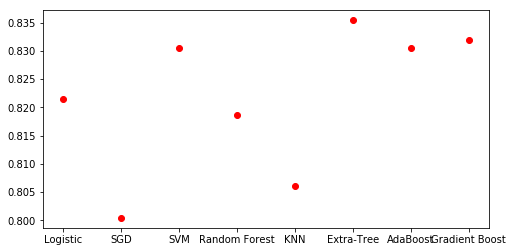

In [127]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.plot(['Logistic', 'SGD', 'SVM', 'Random Forest', 'KNN', 'Extra-Tree', 'AdaBoost', 'Gradient Boost'], [log_scores, sgd_scores, svm_scores, rnd_forest_scores, knn_scores, grid_ext_scores, grid_ada_scores, grid_gb_scores], 'ro')

plt.show()

It seems like the best models so far are the SVM, Random Forest, and the KNN. let's try one last thing, the combination of SVM and Random Forest.

In [128]:
voting_clf = VotingClassifier(
    estimators=[('rf', rnd_forest_clf), ('svc', svm_clf), ('knn', grid_knn_clf)],
    voting='hard')

voting_clf.fit (train_set_prepared, survival_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished


VotingClassifier(estimators=[('rf', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [129]:
voting_cross_scores = cross_val_score(voting_clf, train_set_prepared, survival_labels, cv=skfold, scoring="accuracy")
voting_pred = voting_clf.predict(validation_set_prepared).astype(int)
voting_scores = (voting_cross_scores.mean() + accuracy_score (voting_pred, validation_labels))/2
voting_scores 

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  30 | elapsed:    0.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    0.1s remaining:    0.1s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8361469791519363

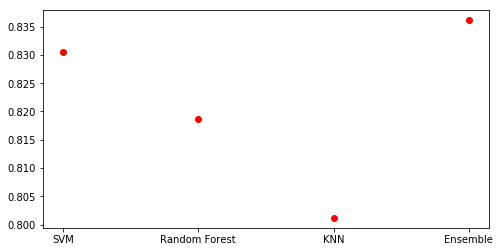

In [130]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.plot(['SVM', 'Random Forest', 'KNN', 'Ensemble'], [svm_scores, rnd_forest_scores, grid_knn_scores, voting_scores], 'ro')

plt.show()

Based on our analysis, it seems like the ensemble method has the highest accuracy. Let's apply this method to the test set and submit the scores to Keggle!

# Step 6. Predicting the survival on test data

In [131]:
test_set_prepared = preprocessor.fit_transform(data_cleaner(test_data))
predictions = voting_clf.predict(test_set_prepared).astype(int)

# Step 7. Creating the Kaggle submission file

In [132]:
#set ids as PassengerId and predict survival 
ids = test_data['PassengerId']
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)